In [27]:
import sys
assert sys.version_info >= (3, 5)
print()

# Common imports
import numpy as np
import os
import pandas as pd

#sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, auc,roc_auc_score, cohen_kappa_score,roc_curve
from sklearn.preprocessing import label_binarize

#tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models


import matplotlib.pyplot as plt
from itertools import cycle

In [11]:
trainData=pd.read_csv('/Users/movina/Desktop/Semester2/F21DLCW/OneDrive/x_train_all.csv')
trainLabel=pd.read_csv('/Users/movina/Desktop/Semester2/F21DLCW/OneDrive/y_train_all.csv')
testData=pd.read_csv('/Users/movina/Desktop/Semester2/F21DLCW/OneDrive/x_test_all.csv')
testLabel=pd.read_csv('/Users/movina/Desktop/Semester2/F21DLCW/OneDrive/y_test_all.csv')

In [16]:
X = trainData.iloc[:, 0:].values  # Assuming pixel data starts from column 1
y = trainLabel.iloc[:, 0].values   # Assuming labels are in the first column

# Normalize pixel values to be between 0 and 1
X = X / 255.0

XTest = testData.iloc[:, 0:].values  # Assuming pixel data starts from column 1
yTest = testLabel.iloc[:, 0].values   # Assuming labels are in the first column

# Normalize pixel values to be between 0 and 1
XTest = XTest / 255.0

# Reshape data to 2D images (assuming images are square)
img_size = int(np.sqrt(X.shape[1]))
X = X.reshape(-1, img_size, img_size, 1)  # 1 for grayscale images, 3 for RGB

# Reshape data to 2D images (assuming images are square)
img_size = int(np.sqrt(XTest.shape[1]))
XTest = XTest.reshape(-1, img_size, img_size, 1)  # 1 for grayscale images, 3 for RGB

# If labels are strings, encode them to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
yTest = label_encoder.fit_transform(yTest)


10

In [17]:
def residual_block(x, filters, kernel_size=3, stride=1):
    # Shortcut
    shortcut = x

    # First convolution layer
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolution layer
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Shortcut connection
    if stride > 1:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='valid')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)

    return x

def build_resnet(input_shape, num_classes):
    input_layer = tf.keras.Input(shape=input_shape)

    # Initial convolution layer
    x = layers.Conv2D(64, 7, strides=2, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)

    # Global average pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully connected layer
    x = layers.Dense(num_classes, activation='softmax')(x)

    # Build the model
    model = models.Model(inputs=input_layer, outputs=x, name='resnet')

    return model

# Example usage
input_shape = (48, 48, 1)  # Adjust input shape based on your images
num_classes = 10  # Adjust based on your classification task
resnet_model = build_resnet(input_shape, num_classes)

# Display the model summary
resnet_model.summary()

Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_40 (Conv2D)             (None, 24, 24, 64)   3200        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_40 (BatchN  (None, 24, 24, 64)  256         ['conv2d_40[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_34 (ReLU)                (None, 24, 24, 64)   0           ['batch_normalization_40[0][

 re_lu_42 (ReLU)                (None, 12, 12, 128)  0           ['add_19[0][0]']                 
                                                                                                  
 conv2d_50 (Conv2D)             (None, 6, 6, 256)    295168      ['re_lu_42[0][0]']               
                                                                                                  
 batch_normalization_50 (BatchN  (None, 6, 6, 256)   1024        ['conv2d_50[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_43 (ReLU)                (None, 6, 6, 256)    0           ['batch_normalization_50[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 6, 6, 256)    590080      ['re_lu_43[0][0]']               
          

 dense_2 (Dense)                (None, 10)           5130        ['global_average_pooling2d_2[0][0
                                                                 ]']                              
                                                                                                  
Total params: 11,189,770
Trainable params: 11,180,170
Non-trainable params: 9,600
__________________________________________________________________________________________________


In [34]:
# Compile the ResNet model
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the ResNet model
resnet_model.fit(X, y, epochs=10, validation_data=(XTest, yTest))

Epoch 1/10
303/303 [==============================] - 105s 343ms/step - loss: 0.0387 - accuracy: 0.9883 - val_loss: 0.0934 - val_accuracy: 0.9715
Epoch 2/10
303/303 [==============================] - 103s 341ms/step - loss: 0.0115 - accuracy: 0.9975 - val_loss: 0.0861 - val_accuracy: 0.9783
Epoch 3/10
303/303 [==============================] - 102s 337ms/step - loss: 0.0268 - accuracy: 0.9926 - val_loss: 0.1500 - val_accuracy: 0.9625
Epoch 4/10
303/303 [==============================] - 101s 333ms/step - loss: 0.0105 - accuracy: 0.9966 - val_loss: 0.1158 - val_accuracy: 0.9670
Epoch 5/10
303/303 [==============================] - 127s 420ms/step - loss: 0.0099 - accuracy: 0.9972 - val_loss: 0.0593 - val_accuracy: 0.9816
Epoch 6/10
303/303 [==============================] - 247s 818ms/step - loss: 0.0120 - accuracy: 0.9966 - val_loss: 0.1047 - val_accuracy: 0.9741
Epoch 7/10
303/303 [==============================] - 102s 337ms/step - loss: 0.0091 - accuracy: 0.9970 - val_loss: 0.0625 -

In [21]:
# Assuming your model is named 'model' and has already been trained

# Predictions on the test set
y_pred = resnet_model.predict(XTest)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot encoded predictions to class labels

# True labels for the test set
y_true = yTest

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')  # 'weighted' for multiclass classification
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred_classes)
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovr')  # 'ovr' for multiclass classification
kappa = cohen_kappa_score(y_true, y_pred_classes)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'ROC-AUC Score: {roc_auc}')
print(f'Cohen\'s Kappa: {kappa}')


97/97 [==============================] - 7s 72ms/step
Accuracy: 0.9912621359223301
Precision: 0.9914084410356867
Recall: 0.9912621359223301
F1 Score: 0.9912580764972413
Confusion Matrix:
[[ 59   1   0   0   0   0   0   0   0   0]
 [  0 719   0   0   0   0   0   0   1   0]
 [  0   1 746   2   1   0   0   0   0   0]
 [  0   0   0 449   0   0   0   0   1   0]
 [  0   2   2   1 649   0   5   0   0   1]
 [  0   0   0   0   0  60   0   0   0   0]
 [  0   0   0   0   0   3  87   0   0   0]
 [  0   5   0   0   0   0   0  55   0   0]
 [  0   0   0   0   0   0   1   0 149   0]
 [  0   0   0   0   0   0   0   0   0  90]]
ROC-AUC Score: 0.9998904544941901
Cohen's Kappa: 0.9892773281615688


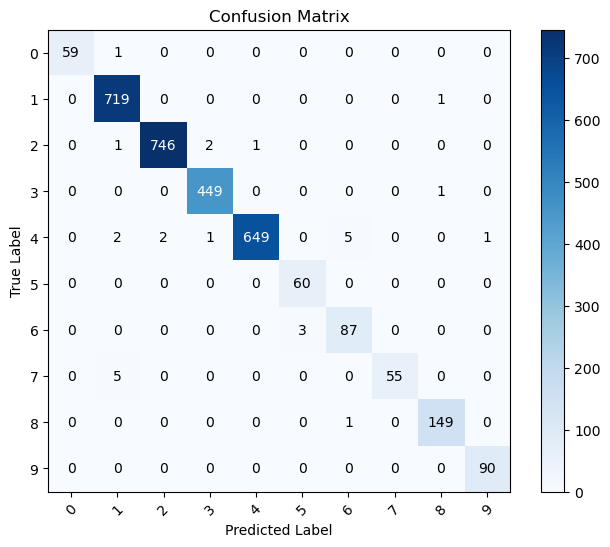

In [23]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = np.unique(y_true)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.show()

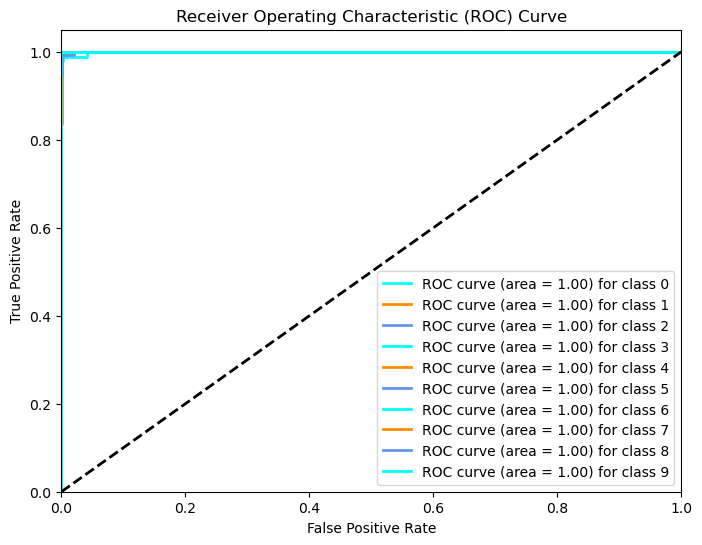

In [28]:
# Plot ROC curve
n_classes = len(np.unique(y_true))
y_true_bin = label_binarize(y_true, classes=range(n_classes))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Plotting the training and validation loss
history = resnet_model.fit(...)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()